In [1]:
# General Imports
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader,random_split, Dataset
%matplotlib inline

In [2]:
# chech GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
device = torch.device(device)
device

device(type='cuda')

In [4]:
smifile = "GDB17.50000000LLnoSR.smi"
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles"])
data = data[:500000]

In [5]:
data.head()

smiles
0    BrC1=C2C3=C4C(CC3CCC2=O)C(=N)NC4=N1
1     BrC1=C2C3C4CCC(C4)C3C(=N)OC2=NC=C1
2     BrC1=C2C3C4CCC(O4)C3(OC2=NC=C1)C#C
3     BrC1=C2C3C4CNC(C4)(C#N)C3OC2=NC=C1
4  BrC1=C2C3=C4C(OC(=O)C4=CC2=O)=CC3=NO1

In [6]:
len(data)

500000

In [7]:
charset = set("".join(list(data.smiles))+"?E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
max_len = max([len(smile) for smile in data.smiles]) + 5

In [8]:
print(f'Charset: {charset}')
print(f'Embedding length: {max_len}')
print(f'Number of characters: {len(charset)}')

Charset: {'F', '6', 's', 'o', '3', '5', 'H', 'n', '1', 'N', '4', '=', '-', 'C', 'l', '#', '+', ']', 'O', ')', 'I', '7', 'c', 'S', '2', '?', '(', '[', 'E', 'r', 'B'}
Embedding length: 55
Number of characters: 31


In [9]:
def vectorize(smiles):
    ''' Vectorize a list of SMILES strings to a numpy array of shape (len(smiles), embed, len(charset))'''
    X = np.zeros((len(smiles), max_len, len(charset)))
    for i,smile in enumerate(smiles):
        for j,char in enumerate(smile):
            X[i,j,char_to_int[char]] = 1
        X[i,j+1:,char_to_int["?"]] = 1
        X[i,j+2:,char_to_int["E"]] = 1
    return X

In [10]:
X_train = vectorize(data.smiles.values[:3])
X_train[0,:,:]

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [11]:
def devectorize(X):
    ''' Devectorize a numpy array of shape (len(smiles), embed, len(charset)) to a list of SMILES strings'''
    smiles = []
    for i in range(X.shape[0]):
        smile = ""
        for j in range(X.shape[1]):
            smile += int_to_char[np.argmax(X[i,j,:])]
        smiles.append(smile)
    # Remove padding
    smiles = [smile.replace("?","").replace("E","") for smile in smiles]
    return smiles

In [12]:
devectorize(X_train)

['BrC1=C2C3=C4C(CC3CCC2=O)C(=N)NC4=N1',
 'BrC1=C2C3C4CCC(C4)C3C(=N)OC2=NC=C1',
 'BrC1=C2C3C4CCC(O4)C3(OC2=NC=C1)C#C']

In [13]:
class SMILESDataset(Dataset):
    def __init__(self, data, charset, max_len):
        self.data = data
        self.charset = charset
        self.max_len = max_len
        self.char_to_int = {c: i for i, c in enumerate(self.charset)}
        # Vectorize the data in chunks with tqdm
        print("Vectorizing data...")
        self.X = np.zeros((len(self.data), self.max_len, len(self.charset)))
        for i in tqdm(range(0, len(self.data), 10000)):
            self.X[i:i+10000] = self.vectorize(self.data[i:i+10000].smiles.values)
        print("Done! {} SMILES strings vectorized.".format(len(self.data)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X[idx]

    def vectorize(self, smiles):
        ''' Vectorize a list of SMILES strings to a numpy array of shape (len(smiles), embed, len(charset))'''
        X = np.zeros((len(smiles), self.max_len, len(self.charset)))
        for i, smile in enumerate(smiles):
            for j, char in enumerate(smile):
                X[i,j,self.char_to_int[char]] = 1
            X[i,j+1:,self.char_to_int["?"]] = 1
            X[i,j+2:,self.char_to_int["E"]] = 1
        return X

In [14]:
# Convert charset set to list
charset = list(charset)

# Instantiate the dataset and dataloader objects
batch_size = 32
dataset = SMILESDataset(data, charset, max_len)
train_dataset, val_dataset, test_dataset = random_split(dataset, [int(0.8*len(dataset)), int(0.1*len(dataset)), int(0.1*len(dataset))])

Vectorizing data...


  0%|          | 0/50 [00:00<?, ?it/s]

Done! 500000 SMILES strings vectorized.


In [15]:
input_size = len(charset)
hidden_size = 1
num_layers = 2

In [16]:
# rewrite the model to use Encoder and Decoder classes
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        encoded, _ = self.encoder(x)
        return encoded
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(Decoder, self).__init__()
        self.decoder = nn.LSTM(hidden_size, output_size, num_layers, batch_first=True)

    def forward(self, x):
        decoded, _ = self.decoder(x)
        return decoded

In [17]:
class Autoencoder_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Autoencoder_2, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(hidden_size, input_size, num_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [23]:
model = Autoencoder_2(input_size, hidden_size, num_layers)

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [26]:
history = {'train_loss': [], 'val_loss': []}
if os.path.exists('Autoencoder_2_500k_GDB17_l2_h1.pt'):
    model.load_state_dict(torch.load('Autoencoder_2_500k_GDB17_l2_h1.pt'))
    print("Loaded model from disk")
else:
    print("No model found, training from scratch")

No model found, training from scratch


In [33]:
num_epochs = 1
best_val_loss = np.inf
# use appropriate device
model.to(device)
print("Training on {}".format(device))
for epoch in range(num_epochs):
    bar = tqdm(train_loader)
    for batch in train_loader:
        model.train()
        optimizer.zero_grad()
        batch = batch.float()
        batch = batch.to(device)
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        bar.set_description("Epoch: {}/{} | Train Loss: {:.5f}".format(epoch+1, num_epochs, loss.item()))
        bar.update()
    val_bar = tqdm(val_loader)
    for batch in val_loader:
        model.eval()
        batch = batch.float()
        batch = batch.to(device)
        outputs = model(batch)
        val_loss = criterion(outputs, batch)
        val_bar.set_description("Epoch: {}/{} | Val Loss: {:.5f}".format(epoch+1, num_epochs, val_loss.item()))
        val_bar.update()
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            torch.save(model.state_dict(), 'Autoencoder_2_500k_GDB17_l2_h1.pt')
    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())

Training on cuda


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



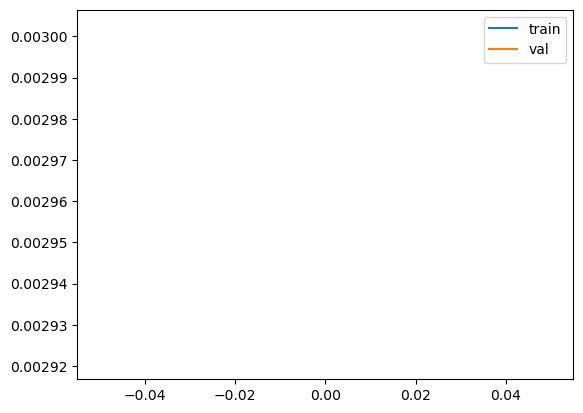

In [34]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.show()

In [35]:
# Test the model
test_loader = DataLoader(dataset=test_dataset, batch_size=20, shuffle=False)
with torch.no_grad():
    incorrect = 0
    for batch in test_loader:
        batch = batch.float()
        batch = batch.to(device)
        outputs = model(batch)
        outputs = outputs.cpu().numpy()
        batch = batch.cpu().numpy()
        smiles = devectorize(batch)
        pred_smiles = devectorize(outputs)
        for i in range(len(smiles)):
            if smiles[i] != pred_smiles[i]:
                incorrect += 1
                print(f'Actual: {smiles[i]}')
                print(f'Predicted: {pred_smiles[i]}')
                print('--------')

Actual: CC1=C2N=CN=C(C)C(C)=CN=C2C(F)=NO1
Predicted: CCN=C2N=CN=C(C)C(C)=CN=C2C(F)=NOB
--------
Actual: CC1C2=C(N=C(N)S2)C(C=C(C)C1(C)C)=NO
Predicted: CCNC2OC(N=C(N)B2CC(C=C(C)CN(C)C)=NO
--------
Actual: CC1=C2N(CC3=CC(=O)SC(CCO)=C23)C=C1
Predicted: CCN=C2N(CC)=CC(=O)BC(CCO)=C2O)C=CN
--------
Actual: CC12OCCC3CCC(=O)C13CCCCC2O
Predicted: CCN2OCCC)CCC(=O)CB)CCCCC2O
--------
Actual: C1CC2=CC(O1)C=CC1CCC2OCO1
Predicted: COCC2[CC(OB)C=CCNCCC2OCOB
--------
Actual: CC12CC(C(O)C#C)C(CCN1)C(C)(C)C2
Predicted: CCN2CC(C(O)C#C)C(CCNN)C(C)(C)C2
--------
Actual: CC1C2CC(C)OC(CC#C)C1C(CO)C2=O
Predicted: CCNC2CC(C)OC(CC#C)CNC(CO)C2OO
--------
Actual: C1OC2=CC3=COC(=NO3)C3=CNC(=N3)C1=C2
Predicted: COOC2OCC)=COC(=NO))C=CNC(=N))CN=C2
--------
Actual: C1CC=C2C(CO1)NC1=C2C2=C(OC=C2)S1
Predicted: COCC=C2C(COB)NCB=C2C2[C(OC=C2CrB
--------
Actual: CC1C2CC(C1=O)C1=C3OCCCC3=C(C)N21
Predicted: CCNC2CC(CN=O)CB=C)OCCCC)=C(C)N2O
--------
Actual: CC1=C2CCCC2=C(O)N=C1CC(=O)C(N)=N
Predicted: CCN=C2CCCC2OC(O)N=CNCC(=O

In [36]:
print(f'Accuracy: {100*(1-incorrect/len(test_dataset)):.2f}%', end='')

Accuracy: 0.00%

In [37]:
def get_models(autoencoder, input_size, hidden_size, num_layers):
    '''
    Returns the encoder and decoder with the same weights as the autoencoder
    '''
    encoder = Encoder(input_size, hidden_size, num_layers)
    decoder = Decoder(hidden_size, input_size, num_layers)
    encoder.load_state_dict(autoencoder.encoder.state_dict())
    decoder.load_state_dict(autoencoder.decoder.state_dict())
    return encoder, decoder

In [38]:
encoder, decoder = get_models(model, input_size, hidden_size, num_layers)

In [39]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
def tanimoto_similarity(smiles1, smiles2):
    '''
    Returns the Tanimoto similarity between two SMILES strings
    '''
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
    return DataStructs.FingerprintSimilarity(fp1, fp2)


In [40]:
# Test the model
encoder.eval()
decoder.eval()
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [41]:
mdma = 'CC(NC)CC1=CC=C(OCO2)C2=C1'
x = vectorize([mdma])
encoded = encoder(torch.Tensor(x))

In [42]:
decoded = decoder(encoded)
print(devectorize(decoded.detach().numpy())[0])

CC(NC)CCN=CC=C(OCO2CC2OCN


In [43]:
tanimoto_similarity(mdma, devectorize(decoded.detach().numpy())[0])

[15:28:09] SMILES Parse Error: extra open parentheses for input: 'CC(NC)CCN=CC=C(OCO2CC2OCN'


ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

In [1]:
mdma in data.Smiles

NameError: name 'mdma' is not defined